In [1]:
import numpy as np
from numpy import pi,exp,sin,cos
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
## Define STDP and Phase coupling function
A_STDP = 0.03
s_STDP = 4
T_theta = pi*2 # theta oscillation period in ms
dp = lambda dt: dt*2*pi/T_theta # dt = xi - xj
omega = lambda dx: A_STDP * exp(s_STDP*cos(dx)) * sin(dx)
# derivative in respect to xi
domega = lambda dx: 2*pi/T_theta*A_STDP*exp(s_STDP*cos(dx)) * (cos(dx) - s_STDP * sin(dx)**2 )


small T_Theta result in large domega (coupling func) thus relatively smaller contribution of k_prior

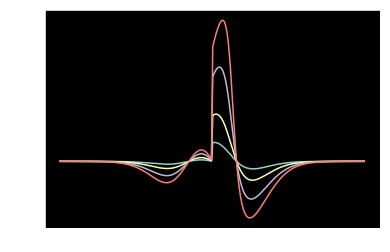

In [3]:
# PRC 
du=np.pi/120 
u = np.arange(-np.pi,np.pi,du) # a bunch of testing phase 
uu=u.copy();uu[u<=0]+=2*np.pi # wrap into range (0,2pi]
PRC = np.zeros_like(u)
k_prior = 0.5 # confidence of prior (x=0)
for w in [0.01,0.025, 0.05, 0.075]:
        for i,xj in enumerate(uu):
                x=0 # postsynaptic start from 0 phase
                t=xj*T_theta/pi/2 # phase response integrate from presynaptic fire
                dt = 0.001*T_theta
                while (t+dt-x*T_theta/pi/2)<T_theta: # fire when x == t*2pi/T mod 2pi
                        dx = dt*(-k_prior*np.sin(x)+w*domega(x-xj))
                        x+=dx
                        t+=dt
                PRC[i] = x
        plt.plot(u,PRC)

So that a single presynaptic neuron's phase can cause a relatively large effect for given long interaction time (right half)

In [4]:
## Create Memorys
N = 200 # number of neurons
M = 10 # number of memorys
k_prior = 0.5 # concentration parameter for prior distribution
k_cue = 10 # for cue distribution
xMemory = np.random.vonmises(0,k_prior,(N,M))
## Create Synapses
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # 0<=j<i
        for k in range(M):
            W[i,j] += omega(xMemory[i,k]-xMemory[j,k])
            W[j,i] += omega(xMemory[j,k]-xMemory[i,k])
sigma2_W = np.var(W.flatten())


In [5]:
## Define ODE
def mainode(t,x,N,W,sigma2_W,x_tilde,k_prior,k_cue):
    # Additional parameters
    # N: #neurons
    # W: Synpatic weight W[i,j] is from j to i
    # sigma2_W: variance of W
    # x_tilde is the recall cue
    # Calculate phase response H
    H = np.zeros(N)
    for i in range(N):
        dxi = x[i] - x # dxi[j] = x[i] - x[j]
        H[i] = np.dot( W[i,:], domega(dxi) ) # H[i] = \sum_j W_{ij} * domega(xi-xj)
    #
    dx_prior    = -k_prior * sin(x)
    dx_external = -k_cue * sin(x-x_tilde)
    dx_synapse  = H/sigma2_W
    dx = dx_prior + dx_external + dx_synapse
    return dx

In [6]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
x0 = np.random.vonmises(0,k_prior,N)
xNoise = np.random.vonmises(0,k_cue,N)
x_tilde = xTarget + xNoise

# Define firing events
events = [lambda t,x,j=j: sin((x[j] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta
kwargs = {
    'N': N,
    'W': W,
    'k_prior': k_prior,
    'k_cue': k_cue,
    'sigma2_W': sigma2_W,
    'x_tilde': x_tilde
}
sol = solve_ivp(lambda t,y: mainode(t,y,**kwargs),(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


but it also cause larger errors , maybe because 1) k_cue is also relatively weak, 2) large synaptic interaction overshoot away from the proper attractor. 3) something to do with the unbalanced wings

Text(0, 0.5, 'time')

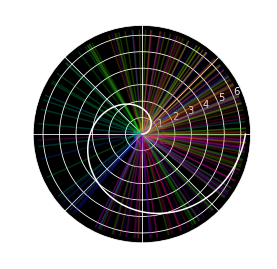

In [7]:
# show time course
from matplotlib.cm import get_cmap
hsv = get_cmap('hsv')
ax = plt.subplot(111,projection='polar')
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.plot(2*pi*t/T_theta,t,color='white')
ax.set_ylabel('time')


Text(0, 0.5, 'counts')

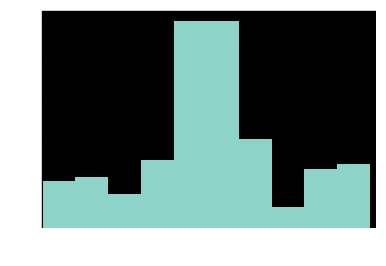

In [8]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi
h=plt.hist(errors[:,-1])
plt.xlim((-pi,pi))
plt.xlabel('error')
plt.ylabel('counts')


In [9]:
## Define STDP and Phase coupling function
A_STDP = 0.03
s_STDP = 4
T_theta = 125 # theta oscillation period in ms
dp = lambda dt: dt*2*pi/T_theta # dt = xi - xj
omega = lambda dx: A_STDP * exp(s_STDP*cos(dx)) * sin(dx)
# derivative in respect to xi
domega = lambda dx: 2*pi/T_theta*A_STDP*exp(s_STDP*cos(dx)) * (cos(dx) - s_STDP * sin(dx)**2 )


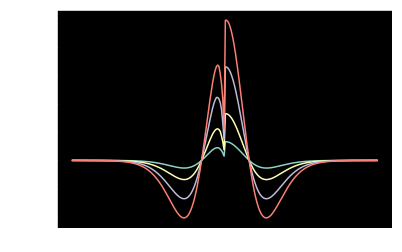

In [10]:
# PRC 
du=np.pi/120 
u = np.arange(-np.pi,np.pi,du) # a bunch of testing phase 
uu=u.copy();uu[u<=0]+=2*np.pi # wrap into range (0,2pi]
PRC = np.zeros_like(u)
k_prior = 0.5 # confidence of prior (x=0)
for w in [0.01,0.025, 0.05, 0.075]:
        for i,xj in enumerate(uu):
                x=0 # postsynaptic start from 0 phase
                t=xj*T_theta/pi/2 # phase response integrate from presynaptic fire
                dt = 0.001*T_theta
                while (t+dt-x*T_theta/pi/2)<T_theta: # fire when x == t*2pi/T mod 2pi
                        dx = dt*(-k_prior*np.sin(x)+w*domega(x-xj))
                        x+=dx
                        t+=dt
                PRC[i] = x
        plt.plot(u,PRC)

larger T_theta -> smaller synaptic interaction -> balance closer to 0 -> smaller effect of intergration time (right half vs left half) 

In [11]:
## Create Memorys
N = 200 # number of neurons
M = 10 # number of memorys
k_prior = 0.5 # concentration parameter for prior distribution
k_cue = 10 # for cue distribution
xMemory = np.random.vonmises(0,k_prior,(N,M))
## Create Synapses
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # 0<=j<i
        for k in range(M):
            W[i,j] += omega(xMemory[i,k]-xMemory[j,k])
            W[j,i] += omega(xMemory[j,k]-xMemory[i,k])
sigma2_W = np.var(W.flatten())


In [12]:
## Define ODE
def mainode(t,x,N,W,sigma2_W,x_tilde,k_prior,k_cue):
    # Additional parameters
    # N: #neurons
    # W: Synpatic weight W[i,j] is from j to i
    # sigma2_W: variance of W
    # x_tilde is the recall cue
    # Calculate phase response H
    H = np.zeros(N)
    for i in range(N):
        dxi = x[i] - x # dxi[j] = x[i] - x[j]
        H[i] = np.dot( W[i,:], domega(dxi) ) # H[i] = \sum_j W_{ij} * domega(xi-xj)
    #
    dx_prior    = -k_prior * sin(x)
    dx_external = -k_cue * sin(x-x_tilde)
    dx_synapse  = H/sigma2_W
    dx = dx_prior + dx_external + dx_synapse
    return dx

In [13]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
x0 = np.random.vonmises(0,k_prior,N)
xNoise = np.random.vonmises(0,k_cue,N)
x_tilde = xTarget + xNoise

# Define firing events
events = [lambda t,x,j=j: sin((x[j] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta
kwargs = {
    'N': N,
    'W': W,
    'k_prior': k_prior,
    'k_cue': k_cue,
    'sigma2_W': sigma2_W,
    'x_tilde': x_tilde
}
sol = solve_ivp(lambda t,y: mainode(t,y,**kwargs),(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'time')

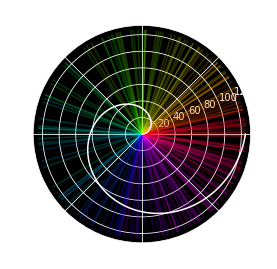

In [14]:
# show time course
from matplotlib.cm import get_cmap
hsv = get_cmap('hsv')
ax = plt.subplot(111,projection='polar')
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.plot(2*pi*t/T_theta,t,color='white')
ax.set_ylabel('time')


starting random. Now larger T_theta generates less error. 

Text(0, 0.5, 'counts')

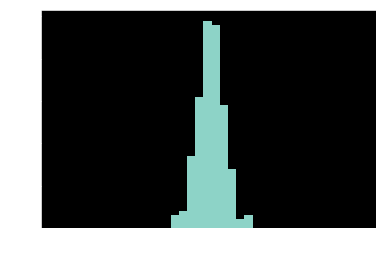

In [15]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi
h=plt.hist(errors[:,-1])
plt.xlim((-pi,pi))
plt.xlabel('error')
plt.ylabel('counts')


In [16]:
## Define STDP and Phase coupling function
A_STDP = 0.03
s_STDP = 4
T_theta = pi*2 # theta oscillation period in ms
dp = lambda dt: dt*2*pi/T_theta # dt = xi - xj
omega = lambda dx: A_STDP * exp(s_STDP*cos(dx)) * sin(dx)
# derivative in respect to xi
domega = lambda dx: 2*pi/T_theta*A_STDP*exp(s_STDP*cos(dx)) * (cos(dx) - s_STDP * sin(dx)**2 )


In [17]:
## Create Memorys
N = 200 # number of neurons
M = 10 # number of memorys
k_prior = 0.5 # concentration parameter for prior distribution
k_cue = 10 # for cue distribution
xMemory = np.random.vonmises(0,k_prior,(N,M))
## Create Synapses
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # 0<=j<i
        for k in range(M):
            W[i,j] += omega(xMemory[i,k]-xMemory[j,k])
            W[j,i] += omega(xMemory[j,k]-xMemory[i,k])
sigma2_W = np.var(W.flatten())


In [18]:
## Define ODE
def mainode(t,x,N,W,sigma2_W,x_tilde,k_prior,k_cue):
    # Additional parameters
    # N: #neurons
    # W: Synpatic weight W[i,j] is from j to i
    # sigma2_W: variance of W
    # x_tilde is the recall cue
    # Calculate phase response H
    H = np.zeros(N)
    for i in range(N):
        dxi = x[i] - x # dxi[j] = x[i] - x[j]
        H[i] = np.dot( W[i,:], domega(dxi) ) # H[i] = \sum_j W_{ij} * domega(xi-xj)
    #
    dx_prior    = -k_prior * sin(x)
    dx_external = -k_cue * sin(x-x_tilde)
    dx_synapse  = H/sigma2_W
    dx = dx_prior + dx_external + dx_synapse
    return dx

In [19]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
xNoise = np.random.vonmises(0,k_cue,N)
x_tilde = xTarget + xNoise
x0 = x_tilde.copy()

# Define firing events
events = [lambda t,x,j=j: sin((x[j] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta
kwargs = {
    'N': N,
    'W': W,
    'k_prior': k_prior,
    'k_cue': k_cue,
    'sigma2_W': sigma2_W,
    'x_tilde': x_tilde
}
sol = solve_ivp(lambda t,y: mainode(t,y,**kwargs),(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


If we start from cue, Even with small T_theta (large synaptic interaction), the recall performance is much better).

Text(0, 0.5, 'time')

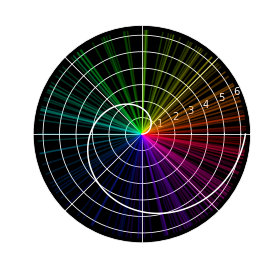

In [20]:
# show time course
from matplotlib.cm import get_cmap
hsv = get_cmap('hsv')
ax = plt.subplot(111,projection='polar')
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.plot(2*pi*t/T_theta,t,color='white')
ax.set_ylabel('time')


Text(0, 0.5, 'counts')

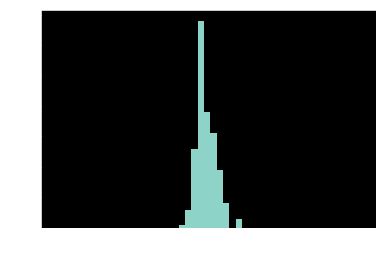

In [21]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi
h=plt.hist(errors[:,-1])
plt.xlim((-pi,pi))
plt.xlabel('error')
plt.ylabel('counts')


In [22]:
## Define STDP and Phase coupling function
A_STDP = 0.03/20
s_STDP = 4
T_theta = pi*2 # theta oscillation period in ms
dp = lambda dt: dt*2*pi/T_theta # dt = xi - xj
omega = lambda dx: A_STDP * exp(s_STDP*cos(dx)) * sin(dx)
# derivative in respect to xi
domega = lambda dx: 2*pi/T_theta*A_STDP*exp(s_STDP*cos(dx)) * (cos(dx) - s_STDP * sin(dx)**2 )


I Also try to see whether I can tune down synaptic interaction by tuning down A_STDP

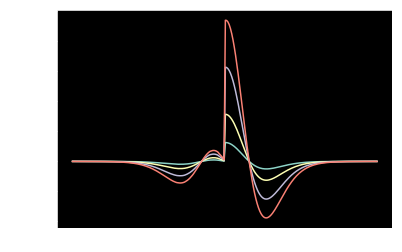

In [23]:
# PRC 
du=np.pi/120 
u = np.arange(-np.pi,np.pi,du) # a bunch of testing phase 
uu=u.copy();uu[u<=0]+=2*np.pi # wrap into range (0,2pi]
PRC = np.zeros_like(u)
k_prior = 0.5 # confidence of prior (x=0)
for w in [0.01,0.025, 0.05, 0.075]:
        for i,xj in enumerate(uu):
                x=0 # postsynaptic start from 0 phase
                t=xj*T_theta/pi/2 # phase response integrate from presynaptic fire
                dt = 0.001*T_theta
                while (t+dt-x*T_theta/pi/2)<T_theta: # fire when x == t*2pi/T mod 2pi
                        dx = dt*(-k_prior*np.sin(x)+w*domega(x-xj))
                        x+=dx
                        t+=dt
                PRC[i] = x
        plt.plot(u,PRC)

This create an overall decrease of synaptic interaction. 

In [24]:
## Create Memorys
N = 200 # number of neurons
M = 10 # number of memorys
k_prior = 0.5 # concentration parameter for prior distribution
k_cue = 10 # for cue distribution
xMemory = np.random.vonmises(0,k_prior,(N,M))
## Create Synapses
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # 0<=j<i
        for k in range(M):
            W[i,j] += omega(xMemory[i,k]-xMemory[j,k])
            W[j,i] += omega(xMemory[j,k]-xMemory[i,k])
sigma2_W = np.var(W.flatten())


In [25]:
## Define ODE
def mainode(t,x,N,W,sigma2_W,x_tilde,k_prior,k_cue):
    # Additional parameters
    # N: #neurons
    # W: Synpatic weight W[i,j] is from j to i
    # sigma2_W: variance of W
    # x_tilde is the recall cue
    # Calculate phase response H
    H = np.zeros(N)
    for i in range(N):
        dxi = x[i] - x # dxi[j] = x[i] - x[j]
        H[i] = np.dot( W[i,:], domega(dxi) ) # H[i] = \sum_j W_{ij} * domega(xi-xj)
    #
    dx_prior    = -k_prior * sin(x)
    dx_external = -k_cue * sin(x-x_tilde)
    dx_synapse  = H/sigma2_W
    dx = dx_prior + dx_external + dx_synapse
    return dx

In [26]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
xNoise = np.random.vonmises(0,k_cue,N)
x_tilde = xTarget + xNoise
x0 = np.random.vonmises(0,k_prior,N)

# Define firing events
events = [lambda t,x,j=j: sin((x[j] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta
kwargs = {
    'N': N,
    'W': W,
    'k_prior': k_prior,
    'k_cue': k_cue,
    'sigma2_W': sigma2_W,
    'x_tilde': x_tilde
}
sol = solve_ivp(lambda t,y: mainode(t,y,**kwargs),(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


And does not help the bad recall performance for random start. 
But note, When drawing PRC curve, the integration only start from presynaptic firing, while in network simulation, it is not the case. 

Text(0, 0.5, 'time')

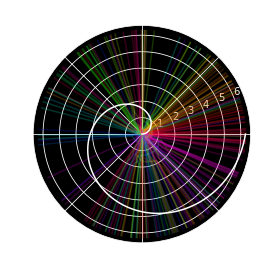

In [27]:
# show time course
from matplotlib.cm import get_cmap
hsv = get_cmap('hsv')
ax = plt.subplot(111,projection='polar')
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.plot(2*pi*t/T_theta,t,color='white')
ax.set_ylabel('time')


Text(0, 0.5, 'counts')

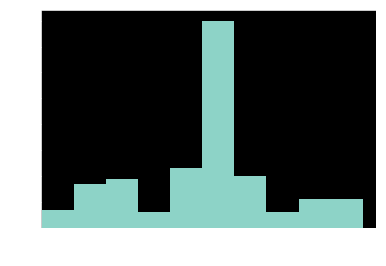

In [28]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi
h=plt.hist(errors[:,-1])
plt.xlim((-pi,pi))
plt.xlabel('error')
plt.ylabel('counts')
